In [2]:
# Portfolio Theory
# 7/1/2015 - 7/1/2018 
# Long only positions / All positions > 0%

# Preparing Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

_data_ = [pd.read_csv('/Users/landonbuechner/Documents/Finance/Mean Variance Analysis/Securities_2/ABBV.csv'),
          pd.read_csv('/Users/landonbuechner/Documents/Finance/Mean Variance Analysis/Securities_2/BABA.csv'),
          pd.read_csv('/Users/landonbuechner/Documents/Finance/Mean Variance Analysis/Securities_2/JPM.csv')]

tickers = ['ABBV','BABA','JPM']

dates = pd.DataFrame(_data_[0])
dates = list(dates['Date'])

# Functions 

def _mean(x):
    x_bar = np.mean(x)
    return [i - x_bar for i in x]

def variance(x):
    mean = sum(x)/len(x)
    square = sum([(i - mean)**2 for i in x]) 
    return square / (len(x) - 1)

def covariance(x,y):
    n = len(x)
    mean_x = _mean(x)
    mean_y = _mean(y)
    means = [mean_x[i] * mean_y[i] for i in range(n)]
    return (sum(means)/n)

def sharpe_ratio(x,y,z):
    return (x-y)/z

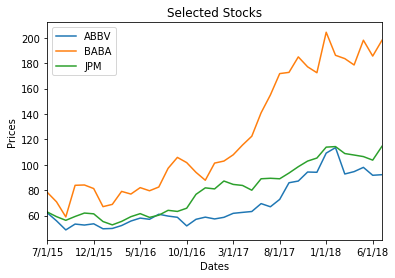

In [3]:
# Formatting Data

prices = {}
for i in range(len(_data_)):
    prices[tickers[i]] = [float(price) for price in _data_[i]['Adj Close']]

returns = {}
for key, value in prices.items():
    returns[key] = [np.log(value[i+1]/value[i]) for i in range(len(value)-1)]
    
x_labels = [i for i in dates[::5]] 
x_labels += '6/1/2018'
prices = pd.DataFrame(prices)
prices.plot()
plt.xticks(np.arange(0, 40, step=5),x_labels)
plt.ylabel('Prices')
plt.xlabel('Dates')
plt.title('Selected Stocks')

plt.show()
    
returns = pd.DataFrame(returns)


In [4]:
# Key statistics 

data = {}
for key, value in returns.items():
    data[key] = [np.mean(value),variance(value),np.mean(value)*12,variance(value)*12]
    
data = pd.DataFrame(data,['Avg Monthly Return','Monthly Variance','Avg Annual Return','Annual Variance'])
print(data)

                        ABBV      BABA       JPM
Avg Monthly Return  0.010918  0.025753  0.016682
Monthly Variance    0.005845  0.011154  0.003037
Avg Annual Return   0.131018  0.309036  0.200182
Annual Variance     0.070139  0.133852  0.036447


In [5]:
# Creating a Variance-Covariance Matrix using a nested for loop

var_cov  = []
for i in range(len(tickers)):
    lis = []
    for g in range(len(tickers)):
        lis.append(covariance(returns[tickers[i]],returns[tickers[g]])*12)
    var_cov.append(lis)

print(pd.DataFrame(var_cov))

          0         1         2
0  0.068191  0.040525  0.028201
1  0.040525  0.130134  0.023639
2  0.028201  0.023639  0.035435


In [9]:
# Cross checking code/data against equal weighted allocation results from PortfolioVisualizer

risk_free_rate = 0.0265 
weights = pd.DataFrame([1/len(tickers) for i in range(len(tickers))])
avg_returns = data.loc['Avg Annual Return']
print()
portfolio_return = np.dot(weights.T,avg_returns)
portfolio_std = np.dot(np.dot(weights.T,var_cov),weights)**.5

print("---- Equally Weighted Portfolio ----")
print()
print('Portfolio Return: %.3f %s (Equally Weighted)' % ((portfolio_return[0]*100),'%'))
print('Portfolio Standard Deviation: %.3f %s (Equally Weighted)' % ((portfolio_std[0][0]*100),'%'))
print('Sharpe Ratio: %.3f (Equally Weighted)' % (sharpe_ratio(portfolio_return,risk_free_rate,portfolio_std)))


---- Equally Weighted Portfolio ----

Portfolio Return: 21.341 % (Equally Weighted)
Portfolio Standard Deviation: 21.564 % (Equally Weighted)
Sharpe Ratio: 0.867 (Equally Weighted)


In [10]:
# Generating portfolio weights to simulate portfolios (10,000 Portfolios)

weights = []
for i in range(10000):
    x = list(np.random.random(len(tickers)))
    x = [i/sum(x) for i in x]
    weights.append(x)
weights = pd.DataFrame(weights,['C%d' % i for i in range(len(weights))])

print(weights.head())
print()
print('-------------------------------------')
print()

# Numerically solving for optimal portfolio

portfolios = {}

portfolios['P_Return'] = list([float(np.dot(list(weights.loc['C%d'%i]),avg_returns)) for i in range(len(weights))])
portfolios['P_STD'] = list([np.sqrt(np.dot(np.dot(list(weights.loc['C%d'%i]),var_cov),weights.loc['C%d'%i])) for i in range(len(weights))])
portfolios['Sharpe Ratio'] = [sharpe_ratio(portfolios['P_Return'][i],risk_free_rate,portfolios['P_STD'][i]) for i in range(len(weights))]
portfolio_metrics = pd.DataFrame(portfolios,['C%d' % i for i in range(len(weights))])

print(portfolio_metrics.tail())

           0         1         2
C0  0.103868  0.330378  0.565753
C1  0.514881  0.282802  0.202317
C2  0.198345  0.353274  0.448381
C3  0.525471  0.200861  0.273668
C4  0.507375  0.327593  0.165032

-------------------------------------

       P_Return     P_STD  Sharpe Ratio
C9995  0.178359  0.206981      0.733684
C9996  0.202656  0.216116      0.815098
C9997  0.165217  0.226807      0.611610
C9998  0.244199  0.225508      0.965373
C9999  0.229947  0.238847      0.851787


---- Optimized Portfolio Weights ----

      ABBV      BABA       JPM
0  0.00242  0.261617  0.735963

-------------------------------------

Annual Portfolio Return: 22.849 %
Annual Portfolio Standard Deviation: 19.327 %
Sharpe Ratio: 1.045

-------------------------------------


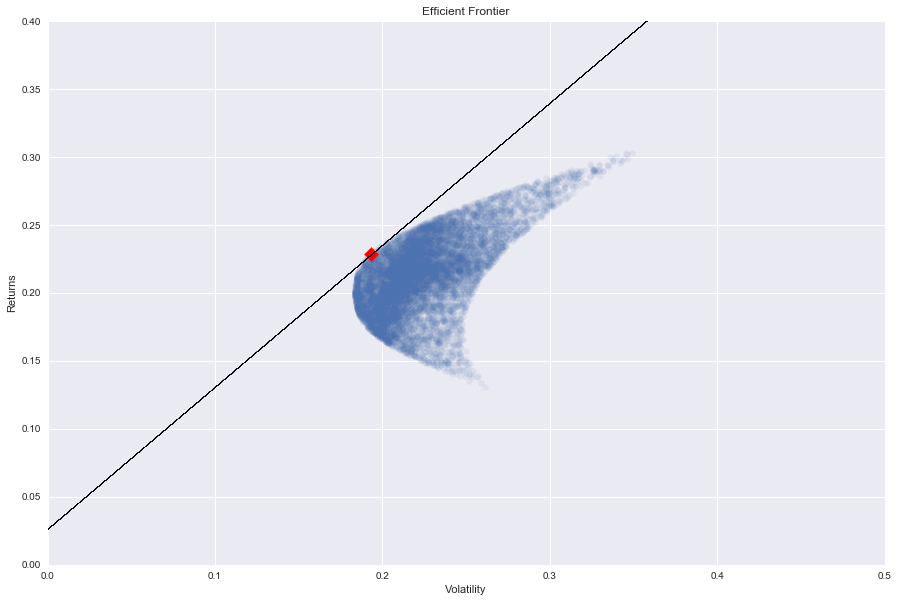

In [11]:
# Finding portfolio weights that historically offer the best risk adjusted return 

maxx = [i for i, j in enumerate(portfolios['Sharpe Ratio']) if j == max(portfolios['Sharpe Ratio'])]
optimal_weights = pd.DataFrame((list(weights.loc['C%d'%(maxx[0])])),tickers)
print("---- Optimized Portfolio Weights ----")
print()
print(optimal_weights.T)
print()
print('-------------------------------------')
print()
conclusion = list(portfolio_metrics.loc["C%d"%(maxx[0])])

print('Annual Portfolio Return: %.3f %s' % (conclusion[0]*100,'%'))
print('Annual Portfolio Standard Deviation: %.3f %s' % (conclusion[1]*100,'%'))
print('Sharpe Ratio: %.3f' % (conclusion[2]))
print()
print('-------------------------------------')

def capital_allocation_line(): #Rp = RFR + SR(Psigma)
    x = [i/80000 for i in range(0,165000)]
    y = [(conclusion[2]*i)+risk_free_rate for i in x]
    return x,y

plt.style.use('seaborn')
plt.figure(figsize=(15, 10))
plt.scatter(portfolios['P_STD'],portfolios['P_Return'],cmap='afmhot', marker='o', s=35, alpha=0.08)
plt.scatter(conclusion[1],conclusion[0], marker = 'D',s=100,c='r')
x,y = capital_allocation_line()

plt.scatter(x,y,marker='.', color = 'k', s=1, )
plt.xlim((0,0.5))
plt.ylim((0,0.4))
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('Efficient Frontier')

plt.show()